In [1]:
from model import MAGNN_nc_mb
import pickle
from utils.data import load_PPMI_data
from utils.tools import index_generator, evaluate_results_nc, parse_minibatch
from pathlib import Path

from sklearn.manifold import TSNE

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_utils as du
data_dir = du.find_data_dir('app')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dataloader_file = du.get_file_path(data_dir, 'class based structure', 'dataloaders', 'dataloader.p')
dataloader = du.read_from_pickle(dataloader_file)

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/home/service/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
adjlists, edge_metapath_indices_list, features_list, adjM, type_mask, labels, train_val_test_idx = load_PPMI_data()
features_list = [torch.FloatTensor(features).to(device) for features in features_list]

feats_type = 0
n_metapaths = 2
etypes_list = [[0, 1, 0], [0, 1, 1, 0]]
hidden_dim = 64
out_dim = 3
num_heads = 8
attn_vec_dim = 128
dropout_rate = 0.5
batch_size = 8
neighbor_samples = 100
rnn_type = 'RotatE0'

if feats_type == 0:
    in_dims = [features.shape[1] for features in features_list]
if feats_type == 2:
    in_dims = [features.shape[0] for features in features_list]
    in_dims[0] = features_list[0].shape[1]
    for i in range(1, len(features_list)):
        dim = features_list[i].shape[0]
        indices = np.vstack((np.arange(dim), np.arange(dim)))
        indices = torch.LongTensor(indices)
        values = torch.FloatTensor(np.ones(dim))
    features_list[i] = torch.sparse.FloatTensor(indices, values, torch.Size([dim, dim])).to(device)
    
    
labels = torch.LongTensor(labels).to(device)
            
net = MAGNN_nc_mb(n_metapaths, 2, etypes_list, in_dims, hidden_dim, out_dim, num_heads, attn_vec_dim, rnn_type, dropout_rate)

train_idx = train_val_test_idx['train_idx']
train_idx = np.sort(train_idx)
test_idx = train_val_test_idx['test_idx']
test_idx = np.sort(test_idx)
val_idx = train_val_test_idx['val_idx']
val_idx = np.sort(val_idx)

net.load_state_dict(torch.load(f'checkpoint/checkpoint_PPMI.pt'))

<All keys matched successfully>

In [32]:
def evaluate_model(idx, train_val_test):
    print(f'Evaluating results for {train_val_test}')
    idx_generator = index_generator(batch_size=batch_size, indices=idx, shuffle=False)
    net.eval()
    embeddings = []
    with torch.no_grad():
        for iteration in range(idx_generator.num_iterations()):
            # forward
            idx_batch = idx_generator.next()
            g_list, indices_list, idx_batch_mapped_list = parse_minibatch(adjlists,
                                                                                         edge_metapath_indices_list,
                                                                                         idx_batch,
                                                                                         device, neighbor_samples)
            logits, embeddings_i = net((g_list, features_list, type_mask, indices_list, idx_batch_mapped_list))
            embeddings.append(embeddings_i)
        embeddings = torch.cat(embeddings, 0)
        svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std = evaluate_results_nc(
            embeddings.cpu().numpy(), labels[idx].cpu().numpy(), num_classes=out_dim)   
    print('')
    return embeddings

train_embeddings = evaluate_model(train_idx, 'Train')
val_embeddings = evaluate_model(val_idx, 'Val')    
test_embeddings = evaluate_model(test_idx, 'Test')    

Evaluating results for Train
SVM test
Macro-F1: 0.624373~0.101967 (0.8), 0.603866~0.063972 (0.6), 0.604238~0.061189 (0.4), 0.548196~0.074903 (0.2)
Micro-F1: 0.684211~0.097048 (0.8), 0.652632~0.063158 (0.6), 0.635088~0.058081 (0.4), 0.597368~0.058312 (0.2)
K-means test
NMI: 0.203077~0.009931
ARI: 0.160483~0.029086

Evaluating results for Val
SVM test
Macro-F1: 0.380652~0.120586 (0.8), 0.363593~0.105343 (0.6), 0.336366~0.091702 (0.4), 0.309814~0.052892 (0.2)
Micro-F1: 0.430769~0.120158 (0.8), 0.392308~0.093897 (0.6), 0.361538~0.092058 (0.4), 0.350000~0.047730 (0.2)
K-means test
NMI: 0.082677~0.012217
ARI: 0.052619~0.011230

Evaluating results for Test
SVM test
Macro-F1: 0.422495~0.141404 (0.8), 0.431820~0.088537 (0.6), 0.420339~0.041382 (0.4), 0.341707~0.087374 (0.2)
Micro-F1: 0.457143~0.132480 (0.8), 0.457143~0.082685 (0.6), 0.450000~0.030952 (0.4), 0.373214~0.072073 (0.2)
K-means test
NMI: 0.086897~0.022179
ARI: 0.078414~0.022475



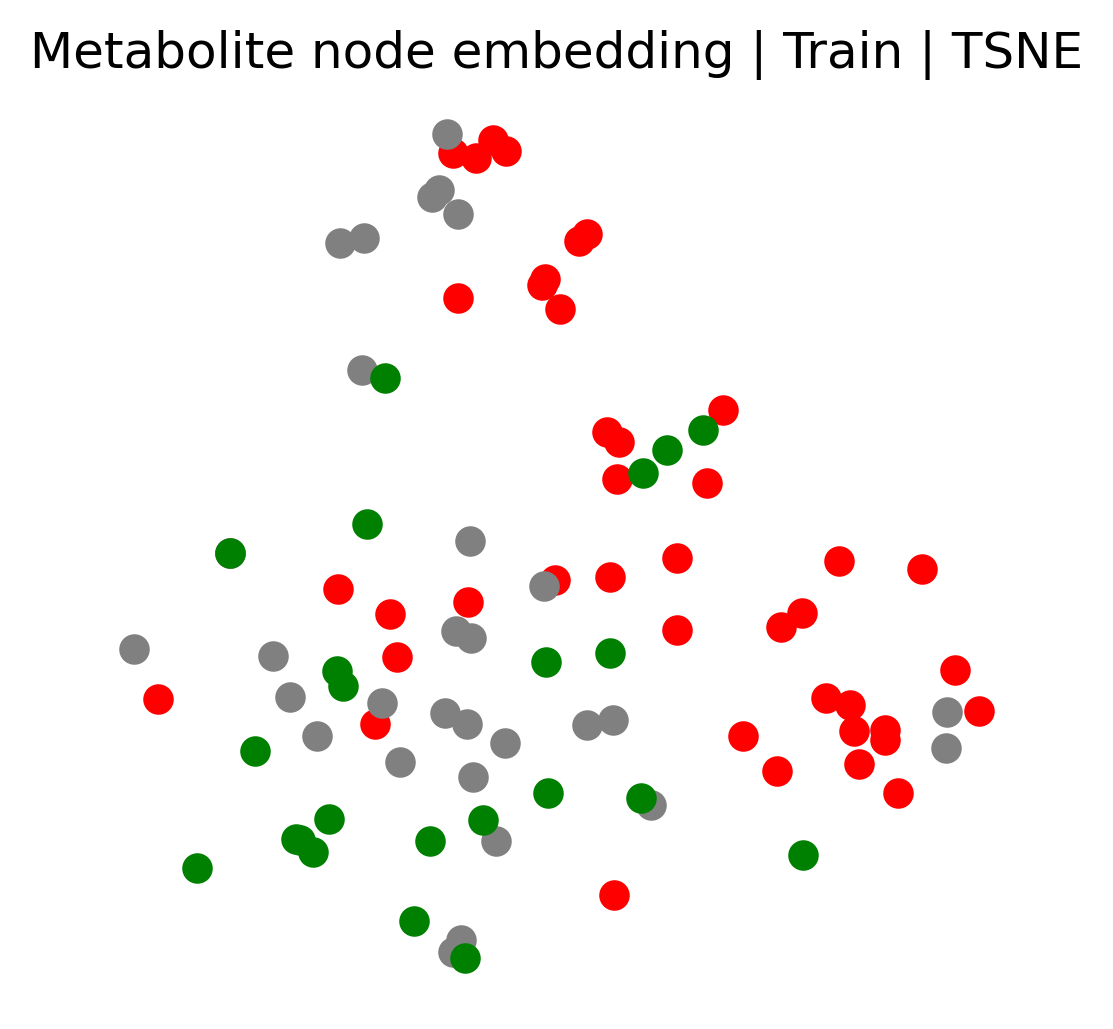

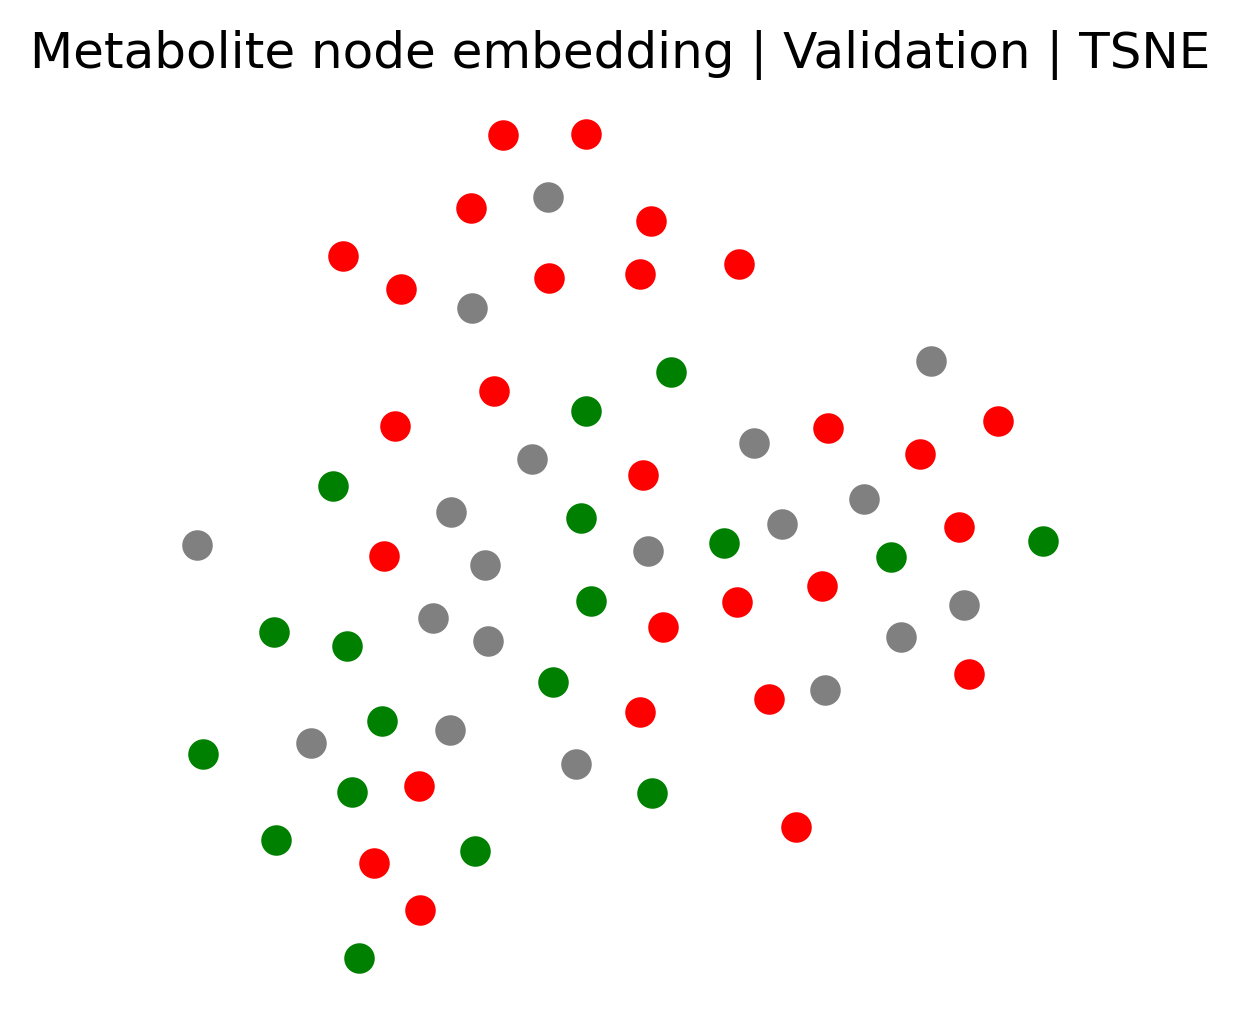

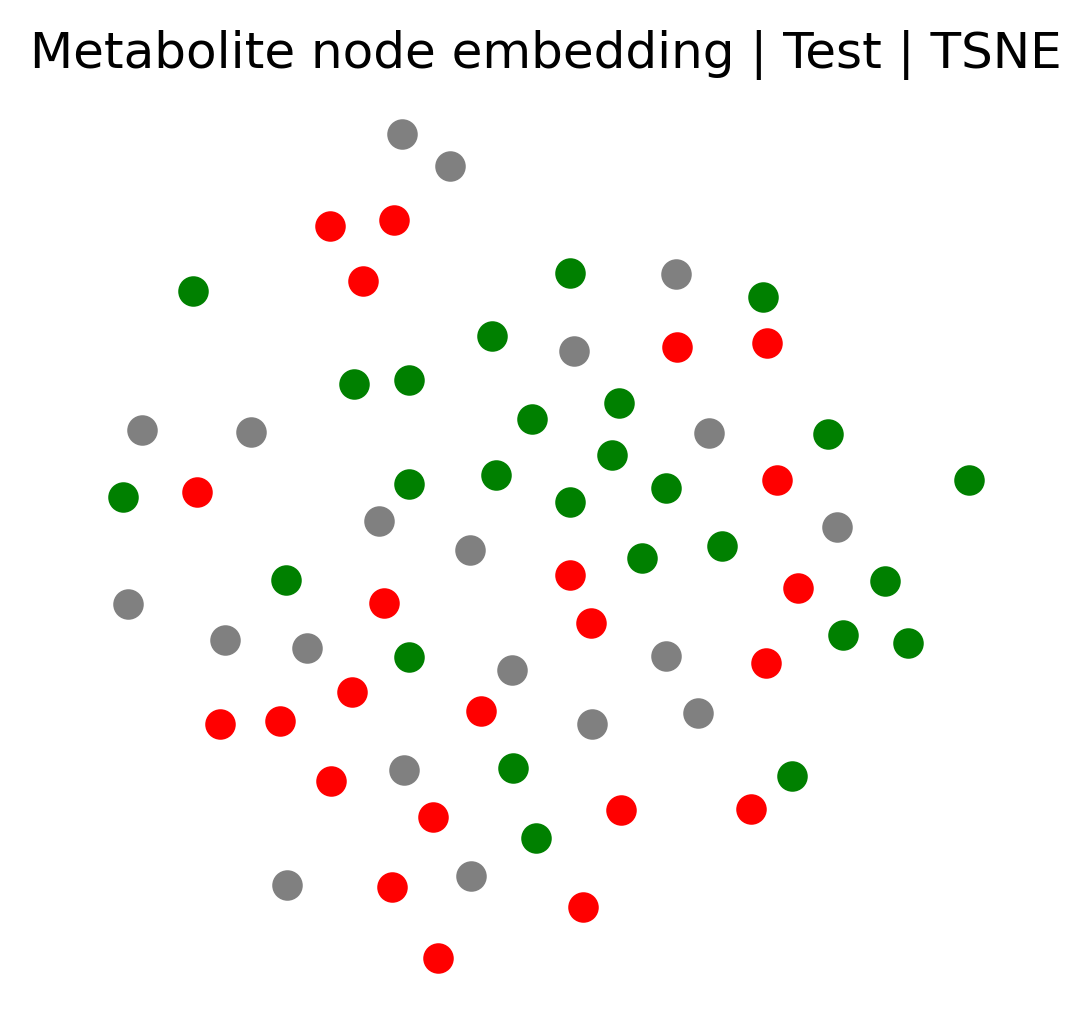

In [28]:
def plot_embedding(embeddings, labels, idx, train_test, method='TSNE', plot_labels=False, CCS=None, highlighted=[], save_fig=False):
    if method=='PCA':
        embedding_2d = torch.pca_lowrank(embeddings, 2)[0]
    elif method=='TSNE':
        embedding_2d = TSNE(n_components=2).fit_transform(embeddings)
    else:
        pass
    
    metabolite_down_mask = np.argwhere(labels[idx]==0)
    metabolite_equal_mask = np.argwhere(labels[idx]==1.)
    metabolite_up_mask = np.argwhere(labels[idx]==2.)

    X_down = embedding_2d[:, 0][metabolite_down_mask][0]
    Y_down = embedding_2d[:, 1][metabolite_down_mask][0]

    X_equal = embedding_2d[:, 0][metabolite_equal_mask][0]
    Y_equal = embedding_2d[:, 1][metabolite_equal_mask][0]
    
    X_up = embedding_2d[:, 0][metabolite_up_mask][0]
    Y_up = embedding_2d[:, 1][metabolite_up_mask][0]
    
    fig = plt.figure(figsize=(4,4), dpi=300)
    fig.patch.set_facecolor('white')    
    
    size = 40
    
    plt.scatter(X_down, Y_down, s=size, c='red', label='CCS = -1')
    plt.scatter(X_equal, Y_equal, s=size, c='gray', label='CCS = 0')
    plt.scatter(X_up, Y_up, s=size, c='green', label='CCS = 1')
    
    if plot_labels:
        fontsize='x-small'
        xy_idx_list_down = list(zip(X_down, Y_down, idx[metabolite_down_mask][0]))
        for x, y, i in xy_idx_list_down:
            if len(highlighted)==0 or (len(highlighted) > 0 and CCS.index[i] in highlighted):
                plt.text(x, y, CCS.index[i][4:], fontsize=fontsize)

        xy_idx_list_equal = list(zip(X_equal, Y_equal, idx[metabolite_equal_mask][0]))
        for x, y, i in xy_idx_list_equal:
            if len(highlighted)==0 or (len(highlighted) > 0 and CCS.index[i] in highlighted):
                plt.text(x, y, CCS.index[i][4:], fontsize=fontsize)
            
        xy_idx_list_up = list(zip(X_up, Y_up, idx[metabolite_up_mask][0]))
        for x, y, i in xy_idx_list_up:
            if len(highlighted)==0 or (len(highlighted) > 0 and CCS.index[i] in highlighted):
                plt.text(x, y, CCS.index[i][4:], fontsize=fontsize)
    
#     plt.legend(bbox_to_anchor=(1.04,1), loc='upper left') #Outside graph
#     plt.legend(loc='upper left')
    title = f'Metabolite node embedding | {train_test} | {method}'
    plt.title(title)
    plt.axis('off')
    
    if save_fig:
        title_stripped = title.replace(' | ', '--')
        filename = f'{title_stripped}.png'
        plt.savefig(Path('Figures', filename), bbox_inches='tight')    
    
    plt.show() 
    return embedding_2d, metabolite_down_mask, idx

# highlighted = ['HMDB0000517', 'HMDB0000904']
highlighted=[]

res = plot_embedding(train_embeddings, labels, train_idx, 'Train', method='TSNE', plot_labels=False, CCS=dataloader.y, highlighted=highlighted, save_fig=True)
res = plot_embedding(val_embeddings, labels, val_idx, 'Validation', method='TSNE', plot_labels=False, CCS=dataloader.y, highlighted=highlighted, save_fig=True)
res = plot_embedding(test_embeddings, labels, test_idx, 'Test', method='TSNE', plot_labels=False, CCS=dataloader.y, highlighted=highlighted, save_fig=True)

In [31]:
dataloader.X

,average_molecular_weight,monisotopic_molecular_weight,"state==""Solid""","state==""Liquid""","super_class==""Organic acids and derivatives""","super_class==""Organic nitrogen compounds""","super_class==""Lipids and lipid-like molecules""","super_class==""Nucleosides, nucleotides, and analogues""","super_class==""Organoheterocyclic compounds""","super_class==""Benzenoids""",...,"""Ovary"" in tissue_locations","""Erythrocyte"" in tissue_locations","""Liver"" in tissue_locations","""Platelet"" in tissue_locations","""Intestine"" in tissue_locations","""Prostate"" in tissue_locations","""Adrenal Medulla"" in tissue_locations","""Epidermis"" in tissue_locations","""Spleen"" in tissue_locations","""Bladder"" in tissue_locations"
hmdb_accession,,,,,,,,,,,,,,,,,,,,,
HMDB0000161,89.0932,89.047678,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HMDB0000517,174.2010,174.111676,1,0,1,0,0,0,0,0,...,1,0,1,1,1,1,0,1,1,1
HMDB0000168,132.1179,132.053492,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HMDB0000191,133.1027,133.037508,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HMDB0000574,121.1580,121.019749,1,0,1,0,0,0,0,0,...,0,0,1,1,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMDB0000060,102.0886,102.031694,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
HMDB0000152,154.1210,154.026609,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
HMDB0000735,209.1986,209.068808,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#Printing all node embeddings at once, do not know if this makes sense
# all_embeddings = torch.cat((train_embeddings, val_embeddings, test_embeddings))
# res = plot_embedding(all_embeddings, labels, np.arange(all_embeddings.shape[0]), 'All', method='TSNE', plot_labels=False, CCS=dataloader.y, highlighted=highlighted)

### Investigating feature value distributions

In [210]:
def create_feature_distribution_df(dataloader, feature_name):
    target_distribution_stats = dataloader.target_distribution_stats()
    df = pd.DataFrame(pd.DataFrame([dataloader.X[feature_name], dataloader.y]).T.value_counts(), columns=['CCS_value_amount']).reset_index()
    df2 = df.loc[:,[feature_name, 'CCS_value_amount']]
    df2 = df2.set_index(feature_name)
    df3 = df2.groupby(df2.index).sum()
    df['feature_value_amount'] = df3['CCS_value_amount'][df[feature_name]].reset_index(drop=True)
    df['value_percentage'] = df['CCS_value_amount'] / df['feature_value_amount'] * 100
    df['original_percentage'] = target_distribution_stats.data.loc[df['CCS']]['Percentage'].reset_index(drop=True)
    df = df.sort_values([feature_name, 'CCS'], ascending=False)
    df['diff_percentage'] = df['value_percentage'] - df['original_percentage']
    df = df.reset_index(drop=True)
    df = df.set_index([feature_name, 'CCS'])
    # cols_to_move = [feature_name, 'feature_value_amount']
    # df           = df[ cols_to_move + [ col for col in df.columns if col not in cols_to_move ] ]
    
    return df.style.format({"value_percentage": "{:.1f}%", "original_percentage": "{:.1f}%",  "diff_percentage": "{:.1f}%"}), df.loc[1, 'value_percentage'], df.loc[1,'original_percentage']

# display(create_feature_distribution_df(dataloader, 'state=="Solid"'))

value_percentages = pd.DataFrame([], columns=[1, 0, -1])

for feature_name in list(dataloader.X.columns)[2:]:
    df_i, value_percentage_i, original_percentage = create_feature_distribution_df(dataloader, feature_name)
    value_percentage_i.name = feature_name
    value_percentages = value_percentages.append(value_percentage_i)
#     display(df_i)
value_percentages

,1,0,-1
original_percentage,29.385965,30.701754,39.912281
"state==""Solid""",26.635514,32.242991,41.121495
"state==""Liquid""",71.428571,7.142857,21.428571
"super_class==""Organic acids and derivatives""",27.848101,29.113924,43.037975
"super_class==""Organic nitrogen compounds""",16.666667,33.333333,50.000000
...,...,...,...
"""Prostate"" in tissue_locations",27.272727,32.323232,40.404040
"""Adrenal Medulla"" in tissue_locations",20.000000,40.000000,40.000000
"""Epidermis"" in tissue_locations",27.419355,37.096774,35.483871
"""Spleen"" in tissue_locations",25.806452,51.612903,22.580645


In [253]:
display_dfs = False
value_percentages_dfs = {}
for feature_name, included in dataloader.include_feature_category['metabolite'].items():
    if included and feature_name not in ['molecular_weight']:
        col_names = list(dataloader.X.columns[[feature_name+'==' in col_name for col_name in dataloader.X.columns]]) + list(dataloader.X.columns[['in ' + feature_name in col_name for col_name in dataloader.X.columns]])
        value_percentages = pd.DataFrame([], columns=[1, 0, -1])
        for col_name in col_names:
            df_i, value_percentage_i, original_percentage = create_feature_distribution_df(dataloader, col_name)
            name = col_name.replace(' in ' + feature_name, '').replace(feature_name + '==', '')
            name = name[1:-1]
            name = f'{name: >80}'
            value_percentage_i.name = name
            if value_percentages.shape[0] == 0:
                original_percentage.name = f'{"Overall distribution": >80}'
                value_percentages = value_percentages.append(original_percentage)
            value_percentages = value_percentages.append(value_percentage_i)
            if display_dfs:
                display(df_i)
        if value_percentages.shape[0] >= 2:
            value_percentages_dfs[feature_name] = value_percentages.fillna(0)

3 bars


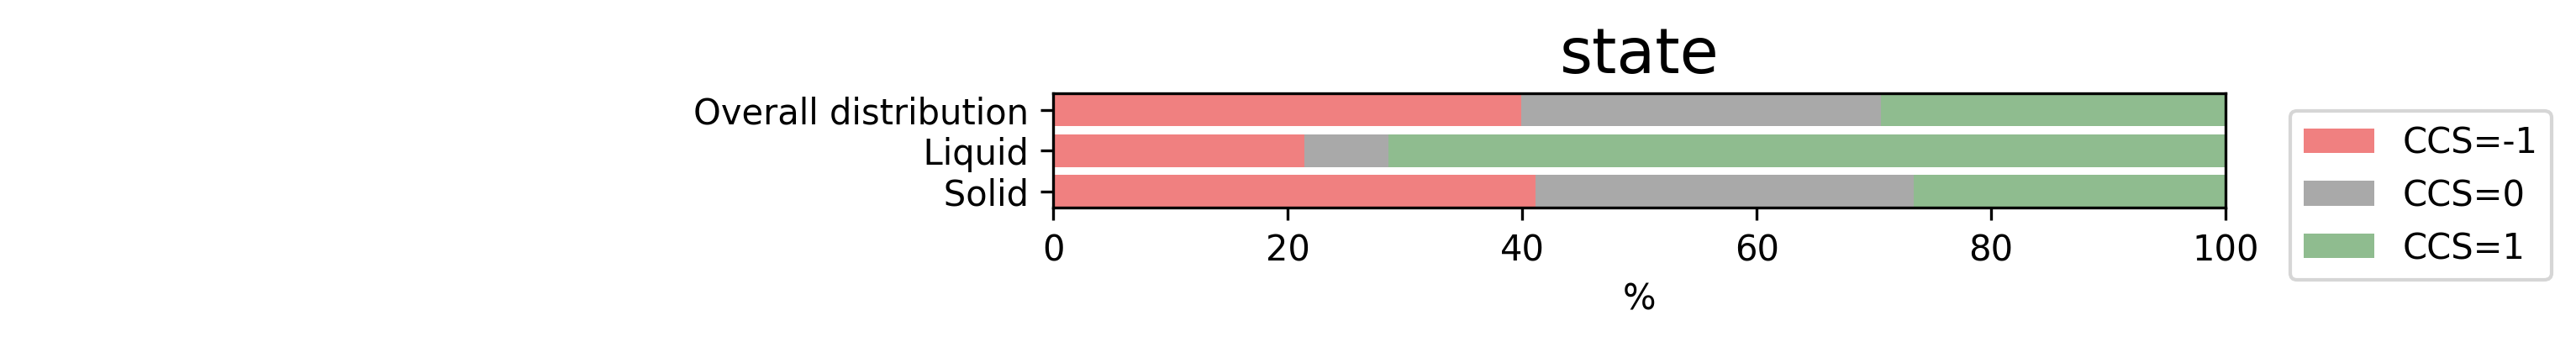

8 bars


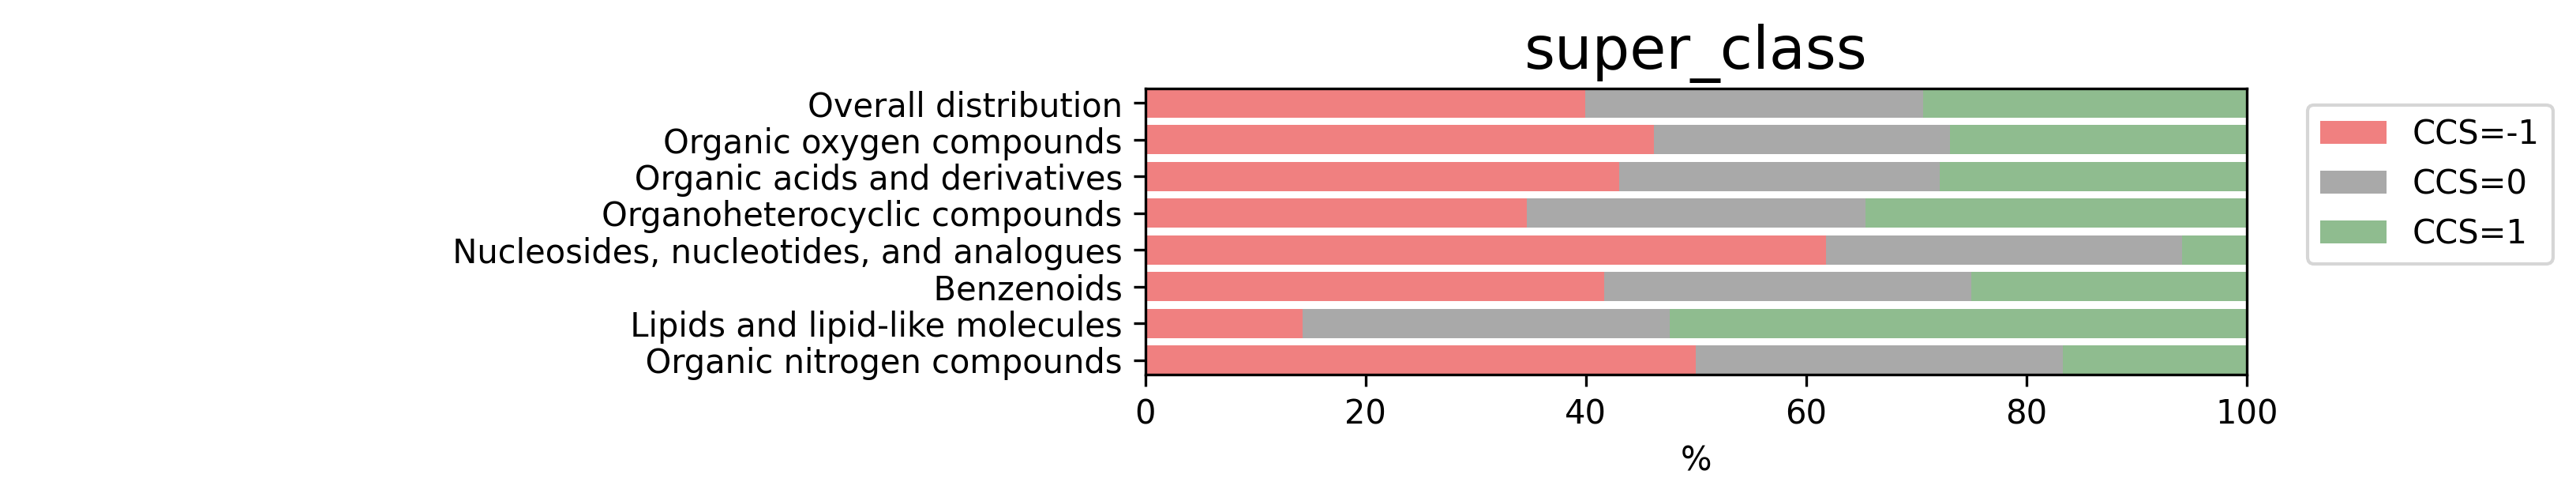

7 bars


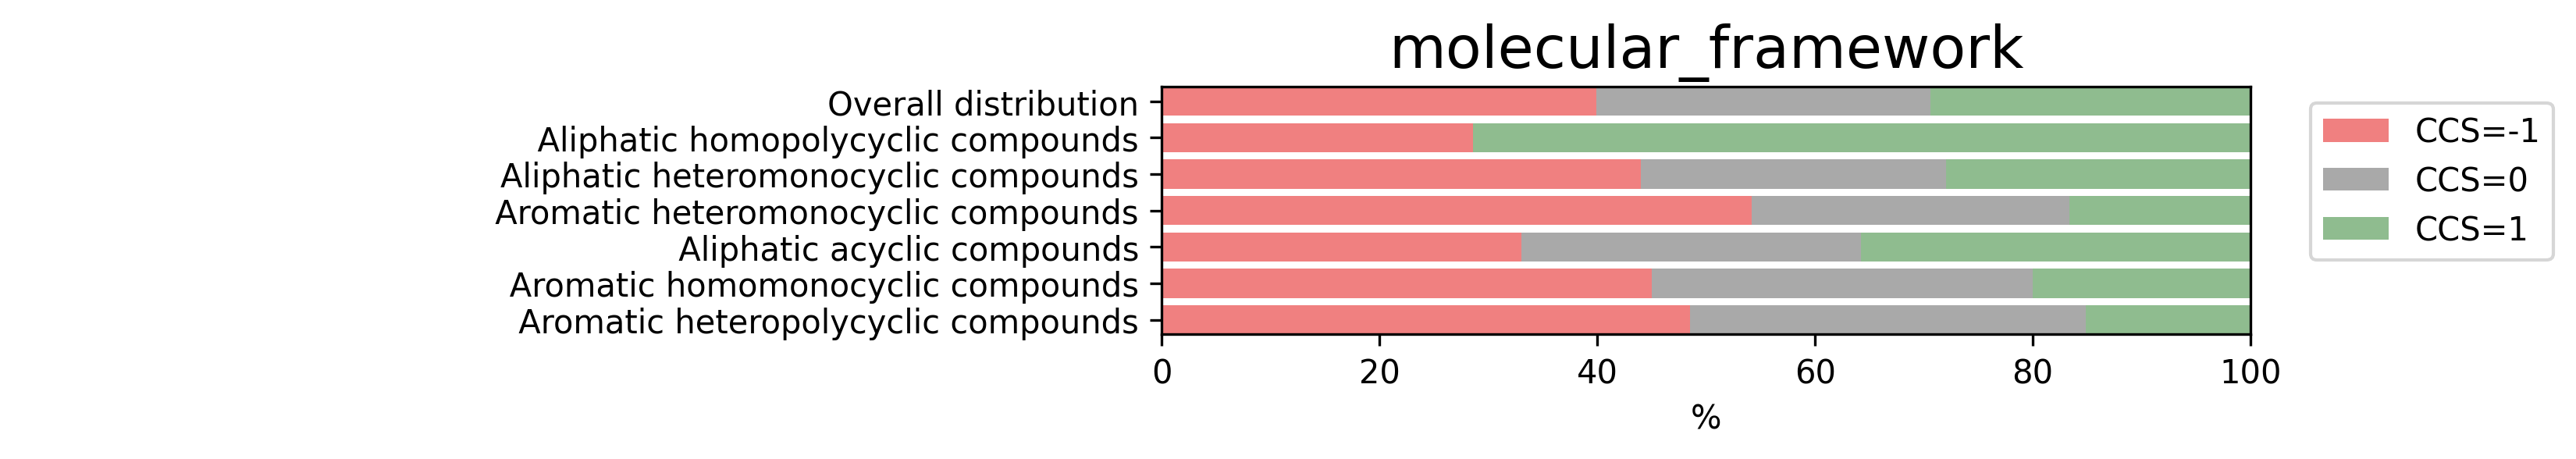

75 bars


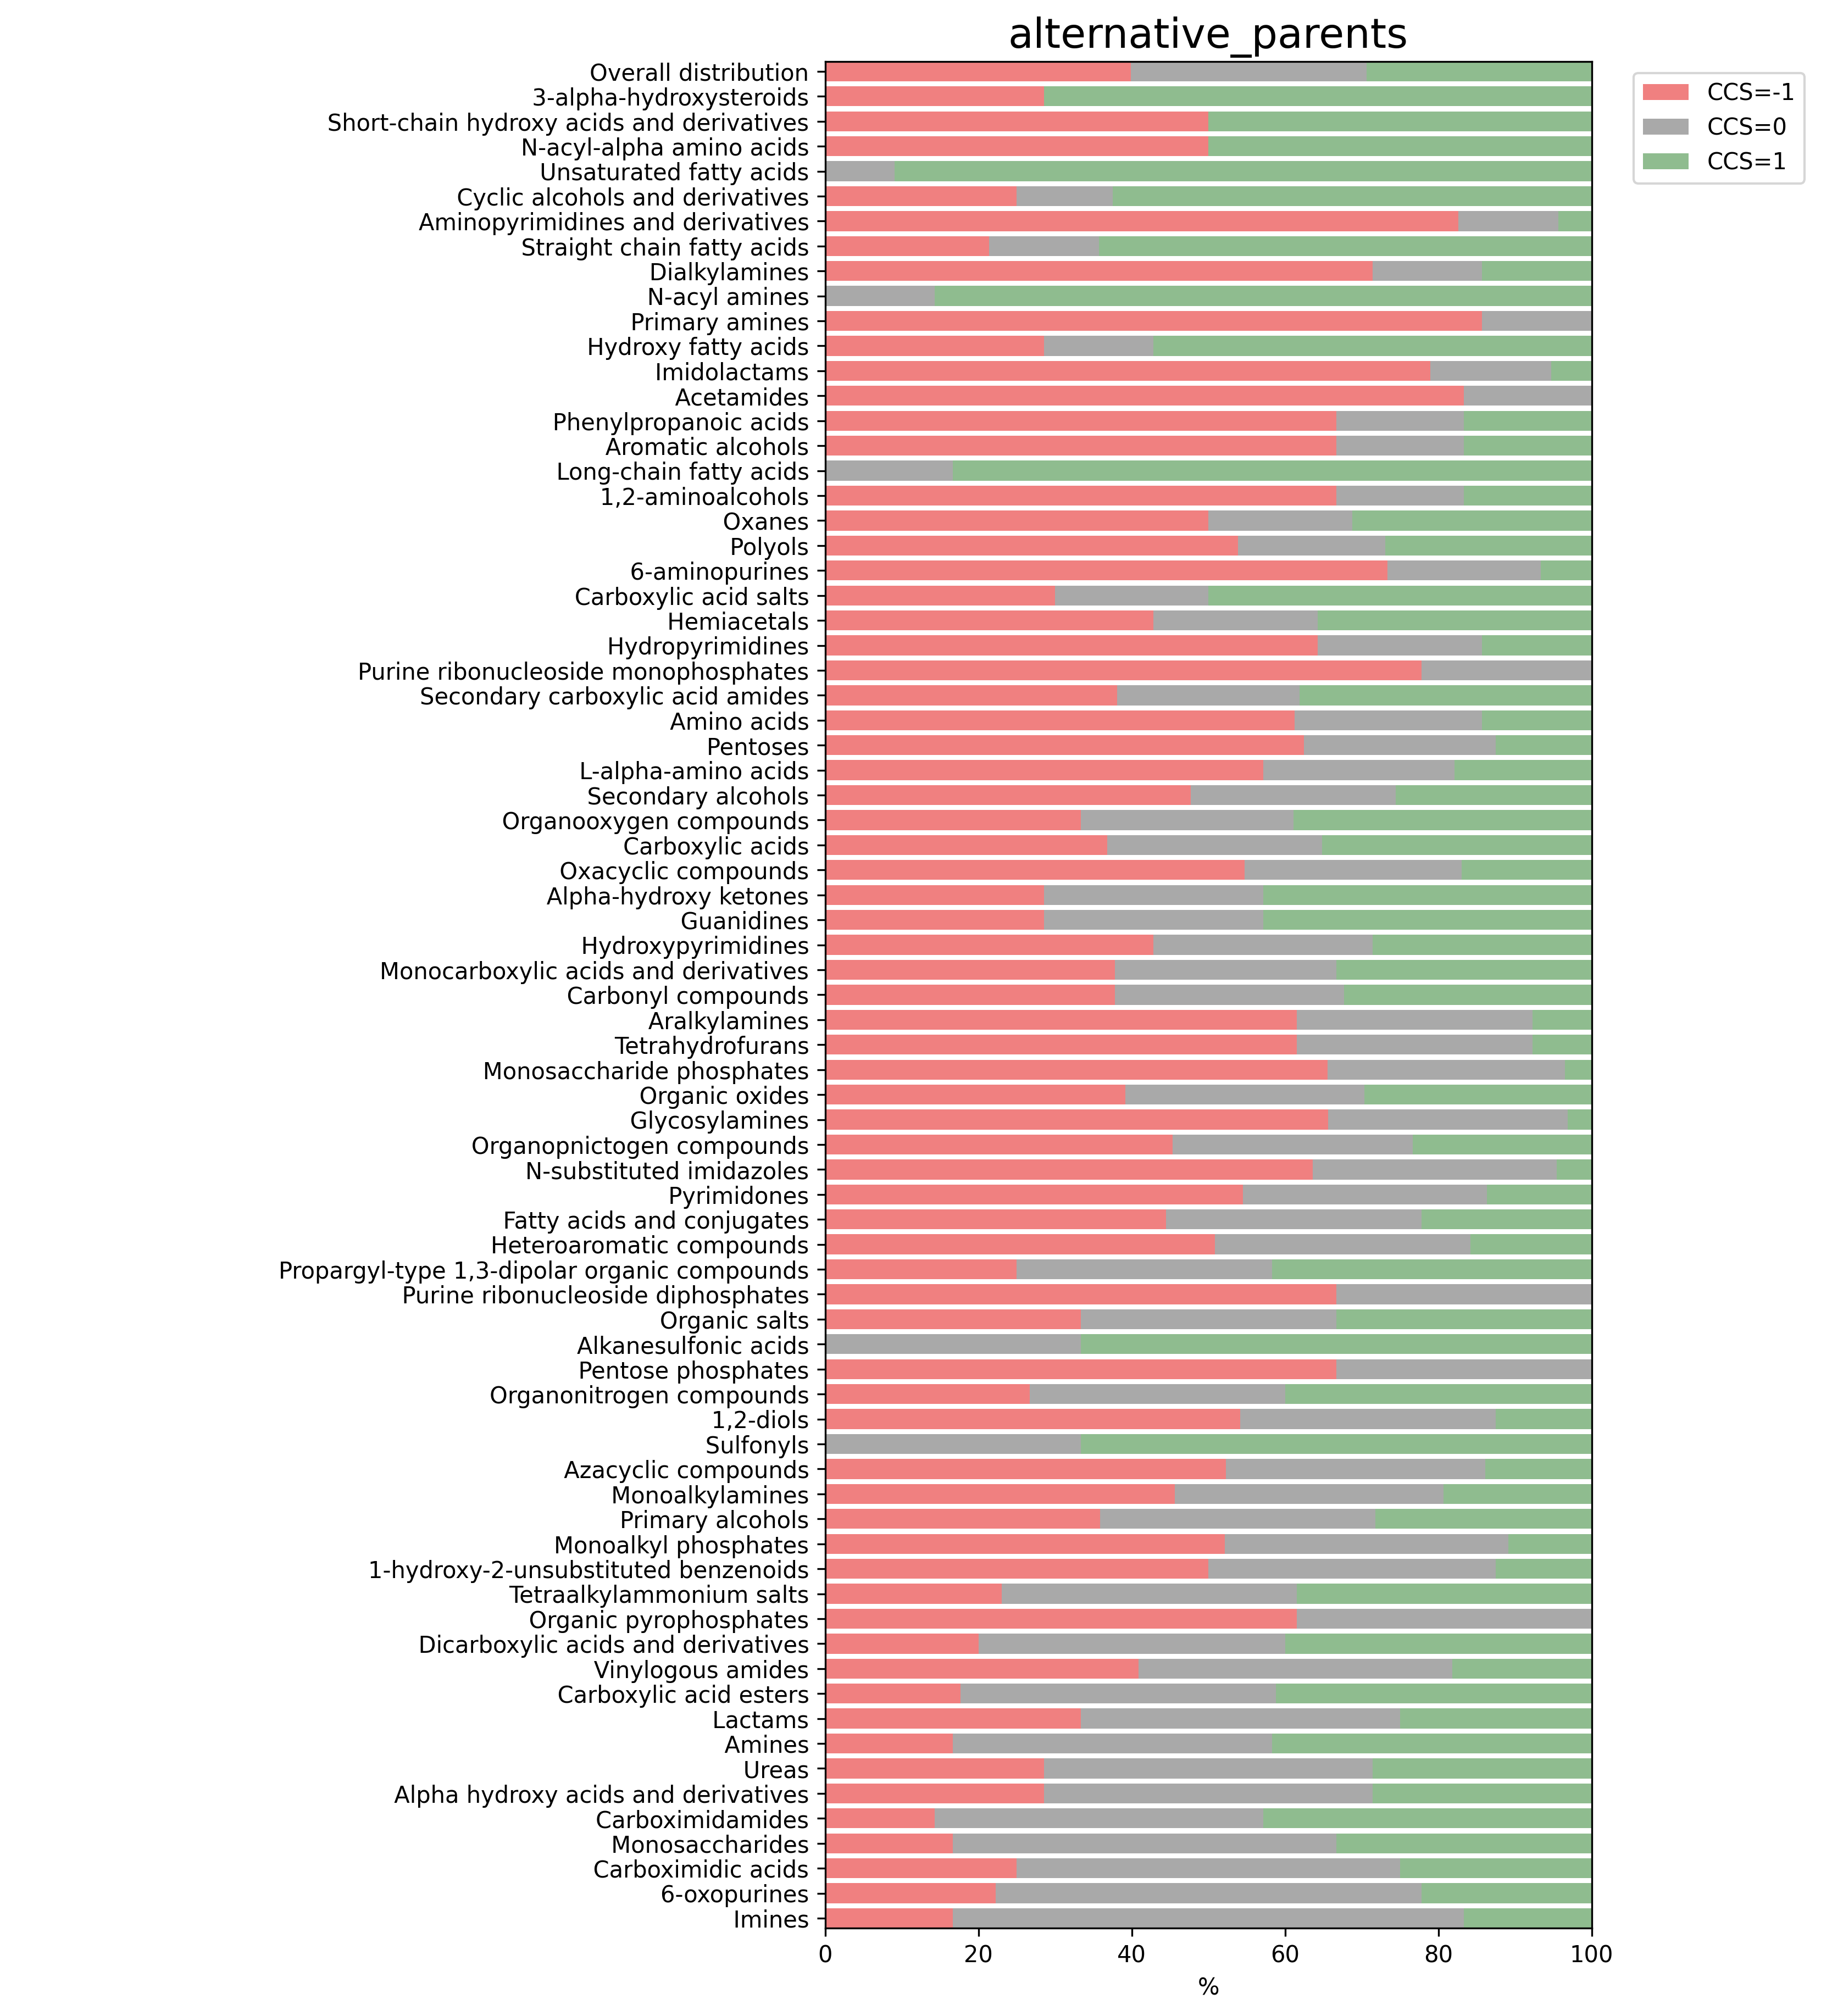

123 bars


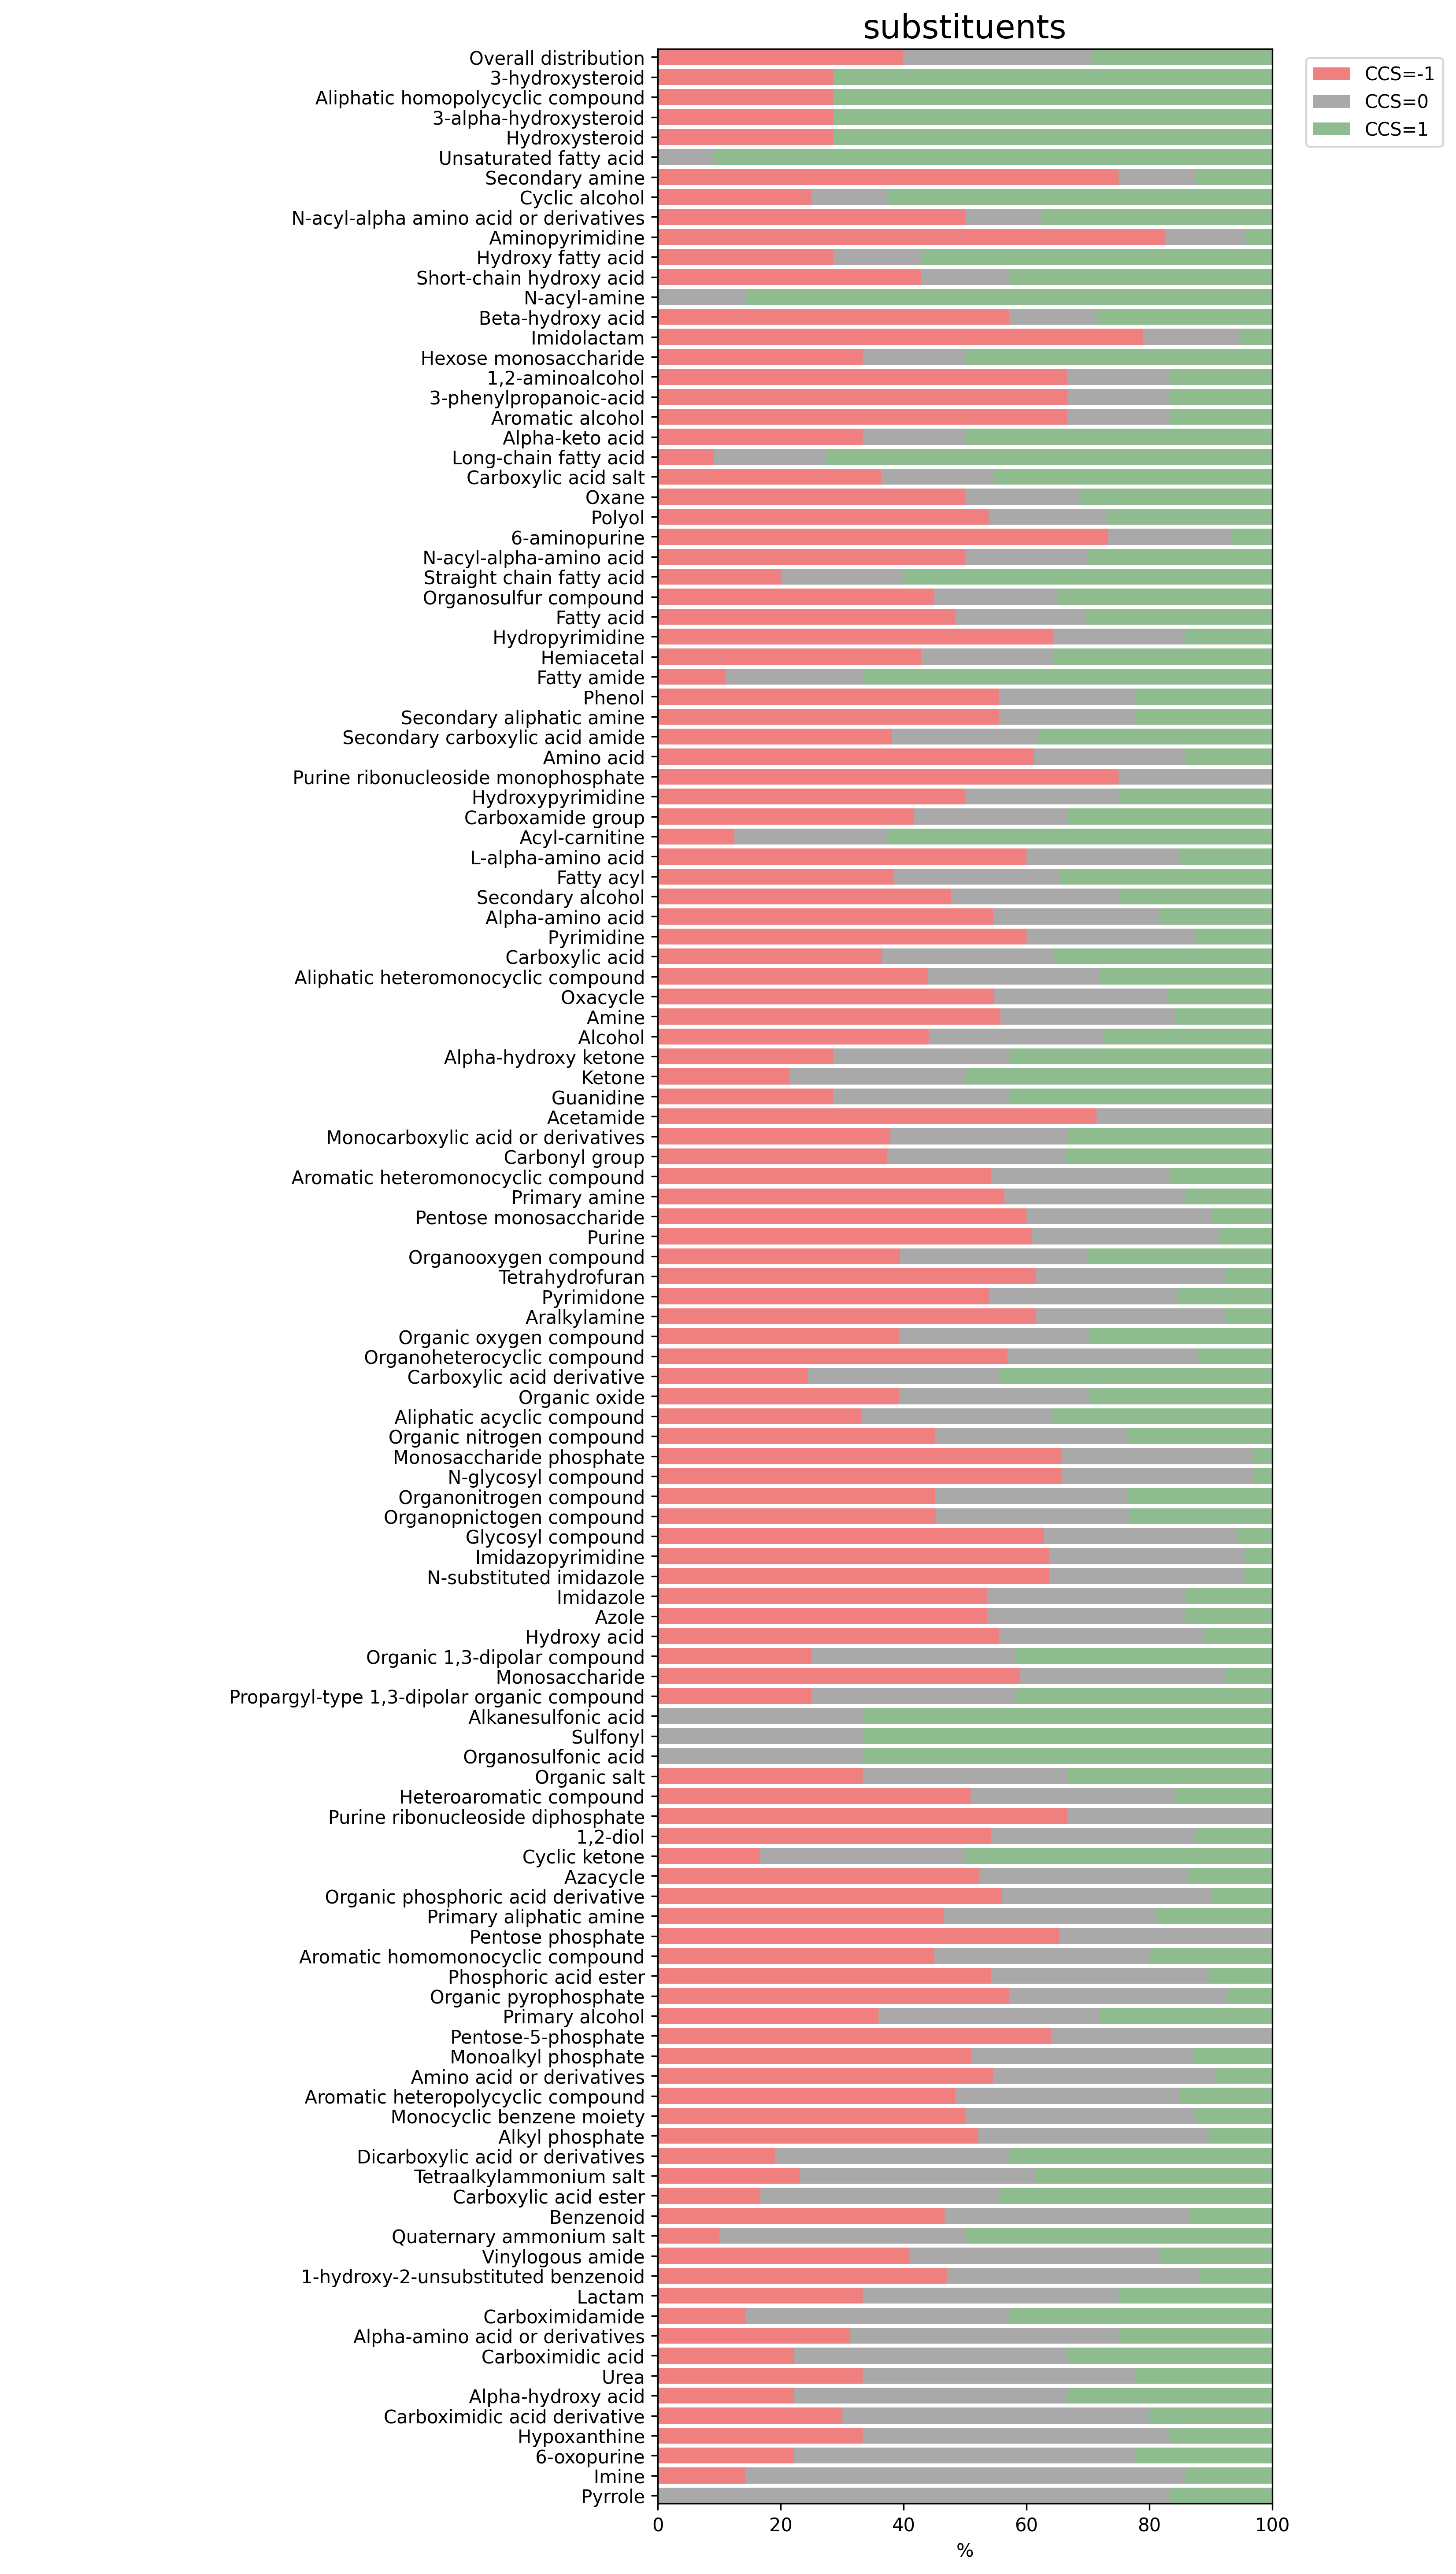

10 bars


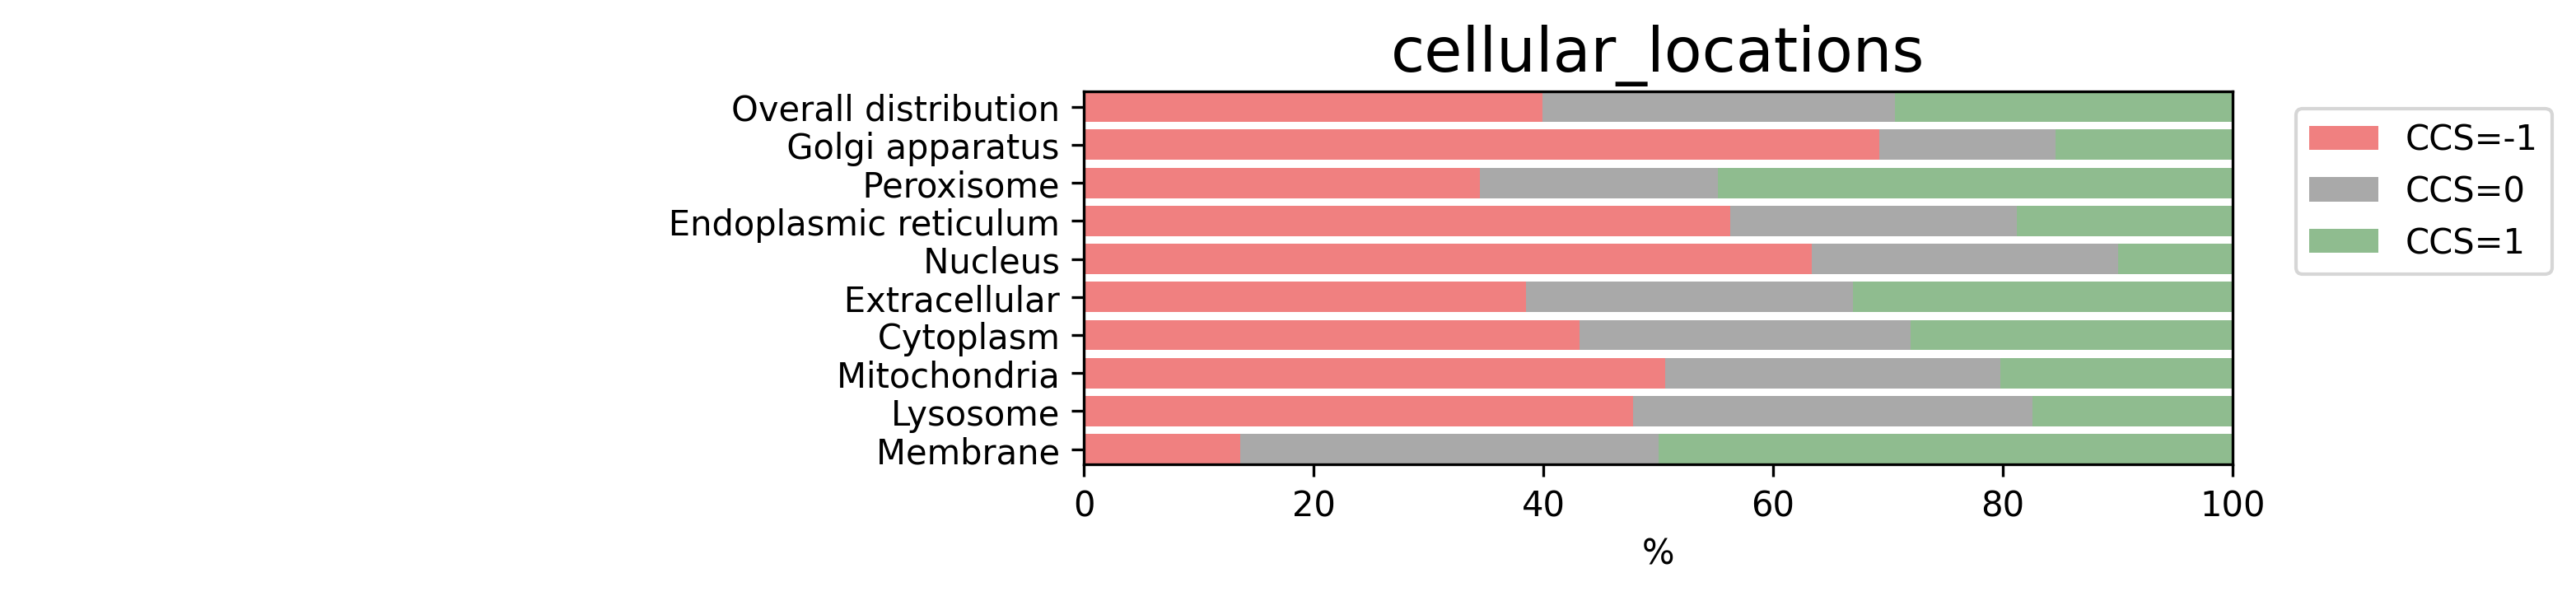

10 bars


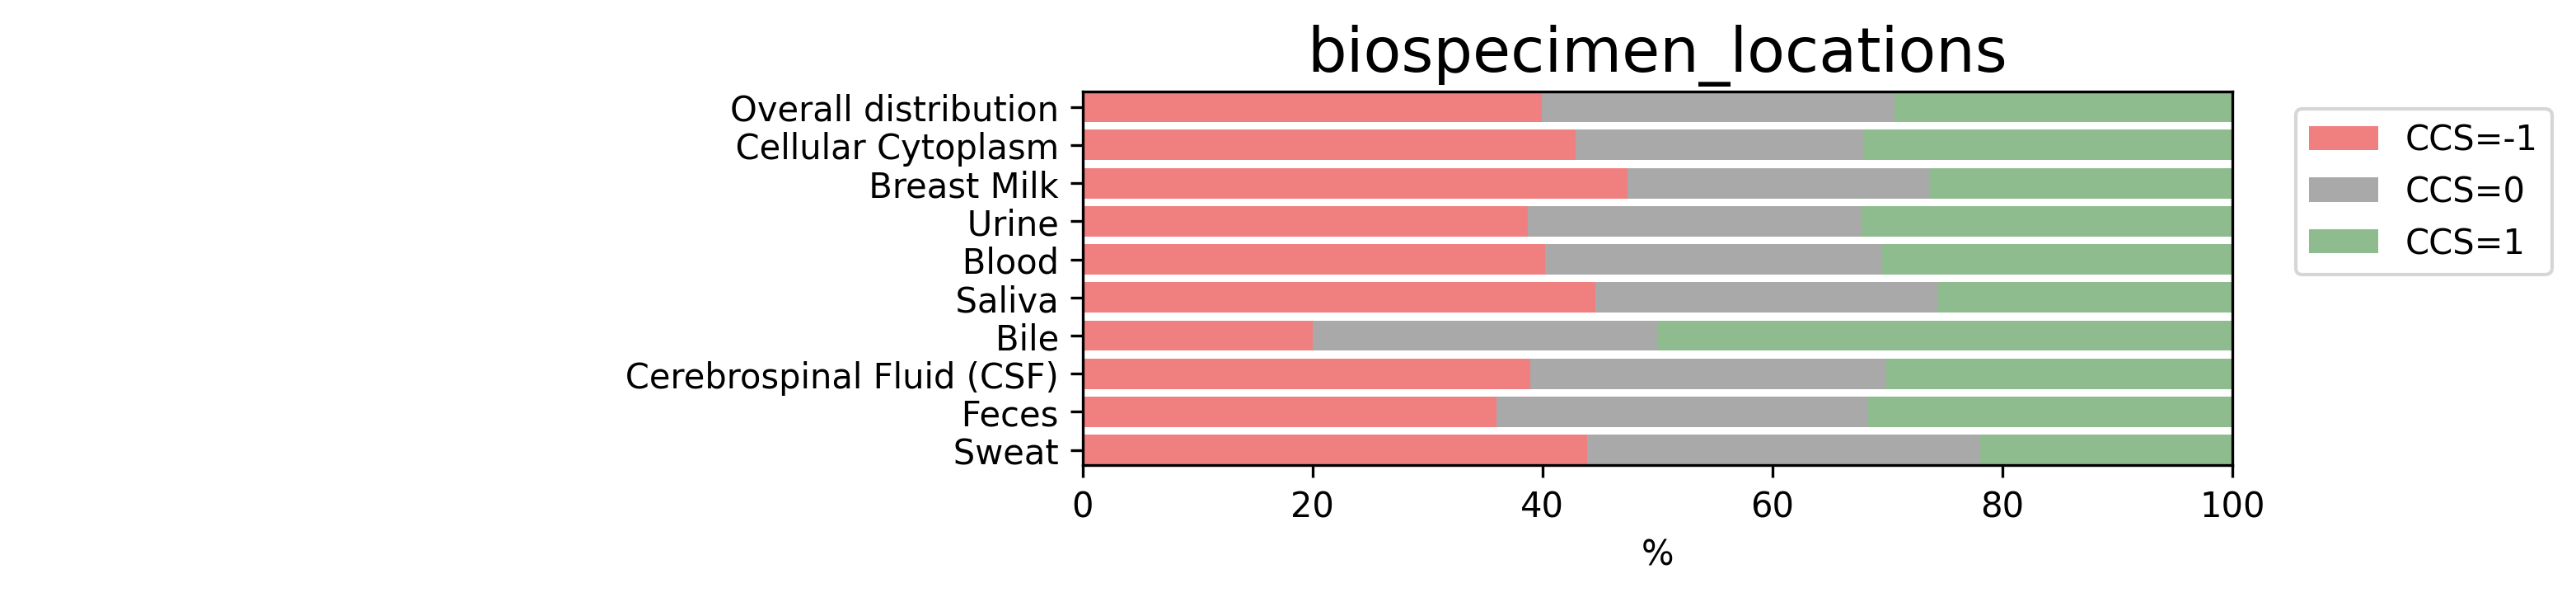

25 bars


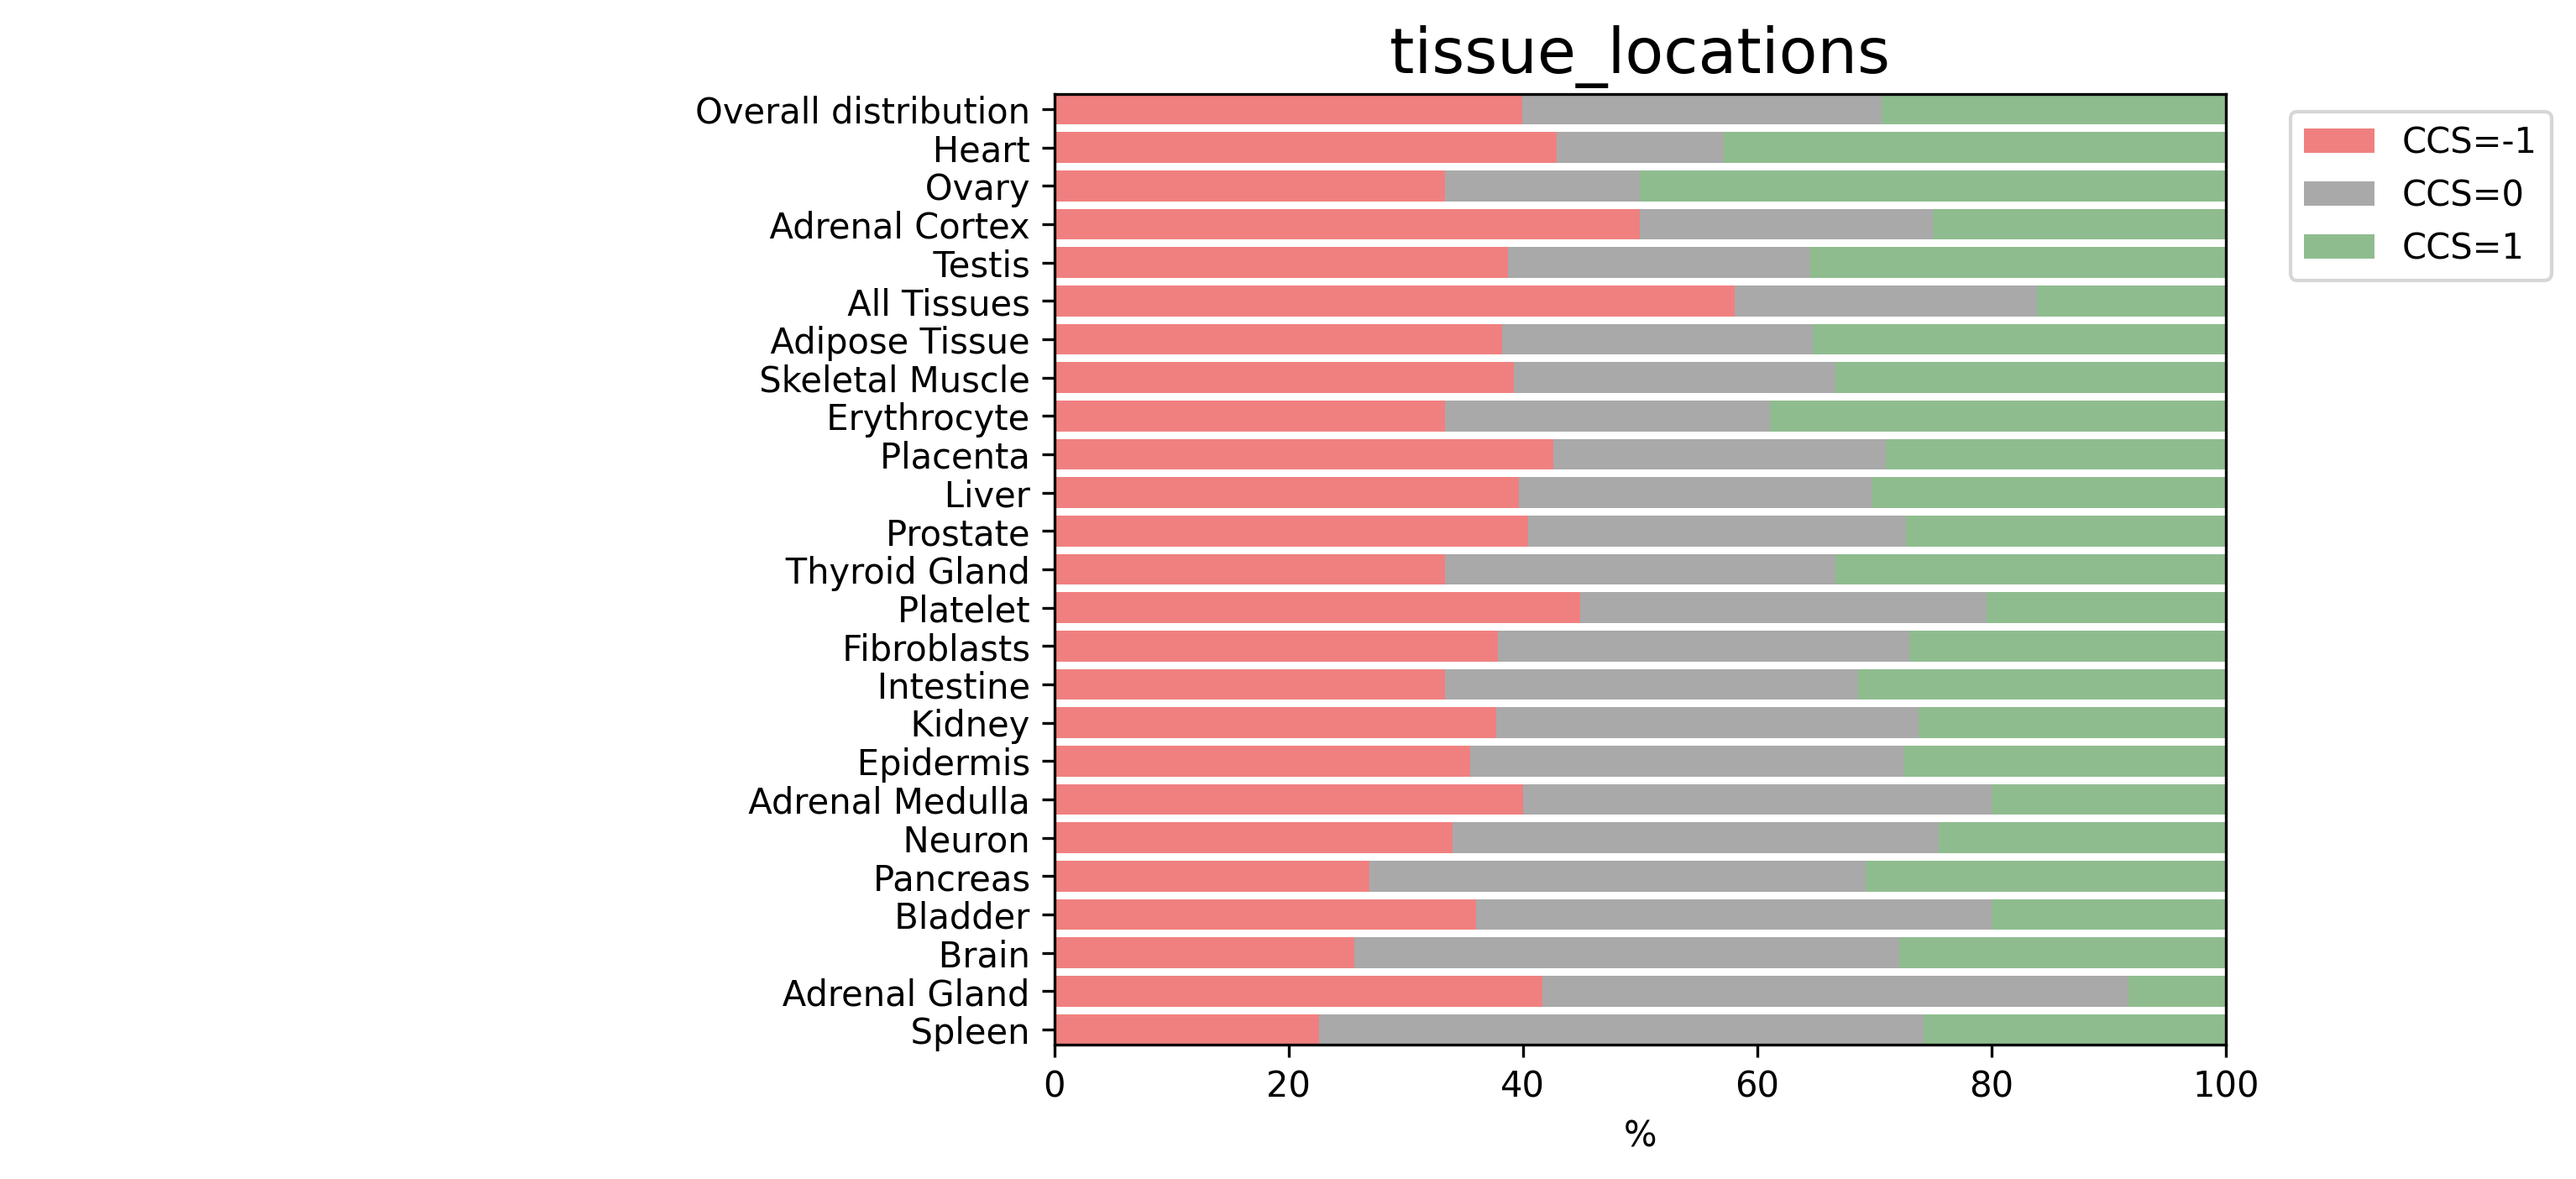

In [256]:
def plot_barh_value_percentages(value_percentages, feature_name, save_fig=False):
    value_percentages = value_percentages.sort_values([0], ascending=False)
#     value_percentages = value_percentages.sort_values([1])
    original_row = f'{"Overall distribution": >80}'
    value_percentages = pd.concat([value_percentages.drop(original_row, axis=0), value_percentages.loc[[original_row],:]], axis=0)
    
    down_values = value_percentages.loc[:, -1].values
    equal_values = value_percentages.loc[:, 0].values
    up_values = value_percentages.loc[:, 1].values
    labels=list(value_percentages.index)

    print(value_percentages.shape[0], 'bars')
    
    fig = plt.figure(figsize=(6, value_percentages.shape[0]/5), dpi=300)
    fig.patch.set_facecolor('white')    
    plt.xlabel('%')
    plt.title(feature_name, fontsize=18)
    plt.margins(0)
    plt.barh(y=labels, width=down_values, label='CCS=-1', color='lightcoral')
    plt.barh(y=labels, width=equal_values, left=down_values, label='CCS=0', color='darkgray')
    plt.barh(y=labels, width=up_values, left=down_values+equal_values, label='CCS=1', color='darkseagreen')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    if save_fig:
        filename = f'barh--{feature_name}.png'
        plt.savefig(Path('Figures', filename), bbox_inches='tight')
    plt.show()

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
    
for feature_name, value_percentages_df in value_percentages_dfs.items():
    plot_barh_value_percentages(value_percentages_df, feature_name, save_fig=True)

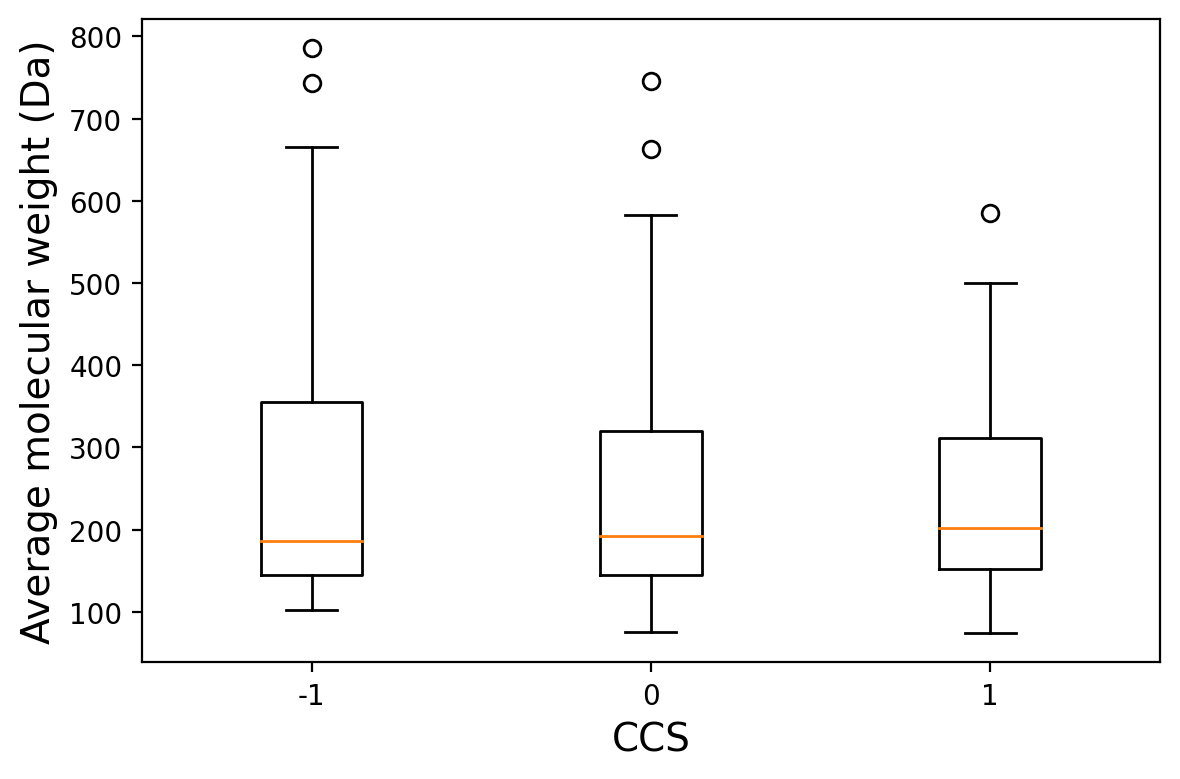

In [34]:
def boxplot_CCS_values(dataloader, feature_name, ylabel=False, save_fig=False):
    metabolite_down_mask = dataloader.y.values==-1
    metabolite_equal_mask = dataloader.y.values==0
    metabolite_up_mask = dataloader.y.values==1

    amw = dataloader.X[feature_name]

    fig = plt.figure(figsize=(6,4), dpi=200)
    fig.patch.set_facecolor('white')    

    plt.boxplot([np.array(amw)[metabolite_down_mask], np.array(amw)[metabolite_equal_mask], np.array(amw)[metabolite_up_mask]], labels=[-1, 0, 1])
    fontsize_labels=14
    plt.xlabel('CCS', fontsize=fontsize_labels)
    if not ylabel:
        ylabel = feature_name
    plt.ylabel(ylabel, fontsize=fontsize_labels)
    
    plt.tight_layout()
    if save_fig:
        filename = f'{ylabel}--vs--CCS'
        plt.savefig(Path('Figures', filename))
    plt.show()
    
boxplot_CCS_values(dataloader,  'average_molecular_weight', 'Average molecular weight (Da)', save_fig=True)
# boxplot_CCS_values(dataloader,  'monisotopic_molecular_weight', 'Monoisotopic molecular weight (Da)')

### Writing results to PDF for discussion

Todo: styling numbers

Multiple df in one pdf

Write text to show which variable

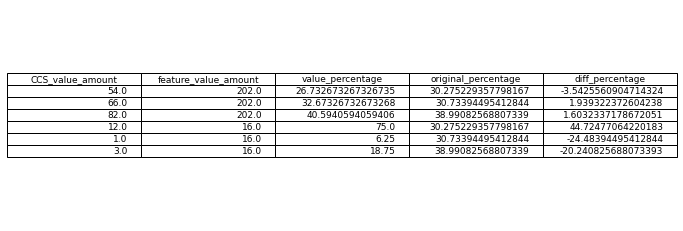

In [23]:
from matplotlib.backends.backend_pdf import PdfPages

df = create_feature_distribution_df(dataloader, 'state=="Solid"').data

#https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')

#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
#https://stackoverflow.com/questions/38686926/write-multiple-dataframes-to-same-pdf-file-using-matplotlib
pp = PdfPages('Sample.pdf')
pp.savefig(fig, bbox_inches='tight')
pp.close()

### Experimentation

In [98]:
features_list[0].shape

torch.Size([218, 445])

In [13]:
train_embeddings.shape
val_embeddings.shape
test_embeddings.shape

torch.Size([66, 512])

In [39]:
CCS.index[1], CCS.index[0]

('HMDB0000517', 'HMDB0000161')

In [114]:
list(CCS.index).index('HMDB0000904')

96

In [59]:
dataloader.PPMI_pruned['HNRNPU']
dataloader.PPMI_pruned['KYNU']

AtlasView({'HMDB0000161': {}, 'RPS6KA1': {}, 'LDHAL6B': {}, 'ADSS': {}, 'NDRG1': {}, 'ASNS': {}, 'NUP210': {}, 'NAGK': {}, 'SEC23IP': {}, 'PPM1G': {}, 'MVD': {}, 'SSU72': {}, 'LYN': {}, 'PEPD': {}, 'SMS': {}, 'CSE1L': {}, 'PALM2': {}, 'SMARCD2': {}, 'BCCIP': {}, 'SGTA': {}, 'GNS': {}, 'C11ORF58': {}, 'LDHA': {}, 'TPM3': {}, 'CNDP2': {}, 'UBC': {}, 'CHORDC1': {}, 'GDA': {}, 'COIL': {}, 'SIRT1': {}, 'SMEK2': {}, 'GSR': {}, 'HMDB0000902': {}, 'HMDB0000684': {}})

In [161]:
target_distribution_stats = dataloader.target_distribution_stats()
target_distribution_stats

,Amount,Percentage
-1,85,39.0%
0,67,30.7%
1,66,30.3%
Total,218,100.0%


In [136]:
list(dataloader.X.loc['HMDB0000904'].index)
dataloader.X.loc['HMDB0000904'][dataloader.X.loc['HMDB0000904']==1.]

state=="Solid"                                          1.0
kingdom=="Organic compounds"                            1.0
super_class=="Organic acids and derivatives"            1.0
class=="Carboxylic acids and derivatives"               1.0
molecular_framework=="Aliphatic acyclic compounds"      1.0
"Mitochondria" in cellular_locations                    1.0
"Blood" in biospecimen_locations                        1.0
"Feces" in biospecimen_locations                        1.0
"Urine" in biospecimen_locations                        1.0
"Saliva" in biospecimen_locations                       1.0
"Cerebrospinal Fluid (CSF)" in biospecimen_locations    1.0
"Sweat" in biospecimen_locations                        1.0
"Fibroblasts" in tissue_locations                       1.0
"Neuron" in tissue_locations                            1.0
"Kidney" in tissue_locations                            1.0
"Placenta" in tissue_locations                          1.0
"Liver" in tissue_locations             

In [138]:
dataloader.X[dataloader.X['class=="Carboxylic acids and derivatives"']==1.]

,average_molecular_weight,monisotopic_molecular_weight,"state==""Solid""","state==""Liquid""","state==""Gas""","state==""nan""","kingdom==""Organic compounds""","kingdom==""Inorganic compounds""","kingdom==""None""","super_class==""Organic acids and derivatives""",...,"""Hair"" in tissue_locations","""Testes"" in tissue_locations","""Adrenal Medulla"" in tissue_locations","""Smooth Muscle"" in tissue_locations","""Epidermis"" in tissue_locations","""Retina"" in tissue_locations","""Basal Ganglia"" in tissue_locations","""Gall Bladder"" in tissue_locations","""Spleen"" in tissue_locations","""Bladder"" in tissue_locations"
hmdb_accession,,,,,,,,,,,,,,,,,,,,,
HMDB0000161,89.0932,89.047678,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
HMDB0000517,174.2010,174.111676,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,1
HMDB0000168,132.1179,132.053492,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
HMDB0000191,133.1027,133.037508,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
HMDB0000574,121.1580,121.019749,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMDB0001229,195.1721,195.053158,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
HMDB0000021,307.0851,306.970537,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
HMDB0000265,650.9735,650.790038,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [30]:
dataloader.X.loc['HMDB0000292'].compare(dataloader.X.loc['HMDB0001185'], keep_equal=True)

,self,other
average_molecular_weight,152.110900,399.445000
monisotopic_molecular_weight,152.033425,399.145064
"super_class==""Nucleosides, nucleotides, and analogues""",0.000000,1.000000
"super_class==""Organoheterocyclic compounds""",1.000000,0.000000
"class==""Imidazopyrimidines""",1.000000,0.000000
"class==""5'-deoxyribonucleosides""",0.000000,1.000000
"""Carboxylic acids"" in alternative_parents",0.000000,1.000000
"""1,2-diols"" in alternative_parents",0.000000,1.000000
"""Pentoses"" in alternative_parents",0.000000,1.000000
"""Amino acids"" in alternative_parents",0.000000,1.000000


In [71]:
dataloader.X.loc['HMDB0000902']

average_molecular_weight               663.425100
monisotopic_molecular_weight           663.109122
state=="Solid"                           1.000000
state=="Liquid"                          0.000000
state=="Gas"                             0.000000
                                          ...    
"Retina" in tissue_locations             0.000000
"Basal Ganglia" in tissue_locations      0.000000
"Gall Bladder" in tissue_locations       0.000000
"Spleen" in tissue_locations             0.000000
"Bladder" in tissue_locations            0.000000
Name: HMDB0000902, Length: 1989, dtype: Sparse[float64, 0]

In [72]:
dataloader.y['HMDB0000902']

0

In [74]:
val_idx

array([  0,   1,  12,  28,  29,  30,  32,  39,  46,  54,  55,  56,  59,
        63,  66,  68,  69,  70,  75,  78,  81,  85,  86,  93,  94,  95,
       101, 103, 105, 110, 111, 122, 128, 132, 133, 134, 137, 144, 150,
       155, 159, 160, 163, 164, 165, 167, 171, 178, 182, 188, 191, 192,
       196, 197, 200, 203, 205, 210, 211, 214, 215])